In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling
from businessscoring import businessgain

In [2]:
#import features for modeling
features = pd.read_csv('Features.csv')

features.columns

Index(['Provider', 'Phys_Count', 'Patient_Count', 'Claim_Count',
       'Service_Type', 'Both_Service', 'Inpatient', 'Outpatient',
       'DuplicateClaims', 'Duplicate_Claims_Percent', 'AvgClaimDuration',
       'Avg_Cost', 'Avg_Age', 'Gender1', 'Gender2', 'Race1', 'Race2', 'Race3',
       'Race5', 'ChronicCond_Alzheimer', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'PotentialFraud', 'NetworkDegree', 'isFraudConnected',
       'NoPhysicianCount'],
      dtype='object')

In [3]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
#features.set_index('Provider', inplace=True)

In [4]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider'], axis=1)
y = features['PotentialFraud'] 

In [5]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Both_Service', 'Inpatient', 'Outpatient',\
            'isFraudConnected']]

#drop dummy variables
X = X.drop(['Both_Service', 'Inpatient', 'Outpatient',\
           'isFraudConnected'], axis =1)

In [6]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled.head()

,Phys_Count,Patient_Count,Claim_Count,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,...,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,NetworkDegree,NoPhysicianCount
0,2.208589,2.111111,1.833861,1.973958,-0.117647,-0.248722,-0.115209,-0.5,2.177606,2.080460,...,1.880482,1.867933,1.919836,1.897468,1.856867,1.793658,1.923621,1.859723,1.333333,2.0
1,-0.490798,0.222222,0.571203,1.098958,1.352941,-0.067768,0.139541,-1.5,0.308880,0.149425,...,0.623388,0.619477,0.583762,0.590488,0.523533,0.608613,0.607261,0.557749,-0.666667,2.0
2,-0.073620,-0.450980,-0.444620,-0.484375,-0.647059,1.419703,0.416436,-2.0,-0.416988,-0.494253,...,-0.427343,-0.440855,-0.448099,-0.447190,-0.435848,-0.423095,-0.445073,-0.438471,-0.666667,0.0
3,0.245399,-0.359477,-0.390823,-0.432292,-0.588235,0.898262,0.747762,0.5,-0.370656,-0.367816,...,-0.382631,-0.374347,-0.409044,-0.395306,-0.392005,-0.383341,-0.375295,-0.388072,-0.333333,0.0
4,-0.441718,1.941176,1.625000,1.578125,-0.411765,0.545887,0.396558,-0.5,2.270270,1.712644,...,1.631126,1.624703,1.667009,1.618283,1.673759,1.651680,1.604903,1.626207,-0.333333,1.0


In [7]:
#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head(5)

,Phys_Count,Patient_Count,Claim_Count,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,NetworkDegree,NoPhysicianCount,Both_Service,Inpatient,Outpatient,isFraudConnected
0,2.208589,2.111111,1.833861,1.973958,-0.117647,-0.248722,-0.115209,-0.5,2.177606,2.080460,...,1.856867,1.793658,1.923621,1.859723,1.333333,2.0,0,0,1,0.0
1,-0.490798,0.222222,0.571203,1.098958,1.352941,-0.067768,0.139541,-1.5,0.308880,0.149425,...,0.523533,0.608613,0.607261,0.557749,-0.666667,2.0,1,0,0,0.0
2,-0.073620,-0.450980,-0.444620,-0.484375,-0.647059,1.419703,0.416436,-2.0,-0.416988,-0.494253,...,-0.435848,-0.423095,-0.445073,-0.438471,-0.666667,0.0,1,0,0,0.0
3,0.245399,-0.359477,-0.390823,-0.432292,-0.588235,0.898262,0.747762,0.5,-0.370656,-0.367816,...,-0.392005,-0.383341,-0.375295,-0.388072,-0.333333,0.0,1,0,0,0.0
4,-0.441718,1.941176,1.625000,1.578125,-0.411765,0.545887,0.396558,-0.5,2.270270,1.712644,...,1.673759,1.651680,1.604903,1.626207,-0.333333,1.0,1,0,0,0.0


In [8]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
#upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    841
0    841
Name: PotentialFraud, dtype: int64

### Examining VIF

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# # the independent variables set 
# X = data[['Gender', 'Height', 'Weight']] 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_Bal.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [round(variance_inflation_factor(X_train_Bal.values, i),3)
                          for i in range(len(X_train_Bal.columns))] 
  
print(vif_data)

                            feature        VIF
0                        Phys_Count      2.897
1                     Patient_Count        inf
2                       Claim_Count  22297.673
3                   DuplicateClaims     38.060
4          Duplicate_Claims_Percent      1.776
5                  AvgClaimDuration      4.251
6                          Avg_Cost      5.064
7                           Avg_Age      1.056
8                           Gender1        inf
9                           Gender2        inf
10                            Race1        inf
11                            Race2        inf
12                            Race3        inf
13                            Race5        inf
14            ChronicCond_Alzheimer   3596.759
15        ChronicCond_KidneyDisease   4119.995
16               ChronicCond_Cancer  10297.676
17       ChronicCond_ObstrPulmonary   4517.779
18           ChronicCond_Depression   4478.161
19             ChronicCond_Diabetes   5873.932
20        Chr

/home/truong/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


### Examining Correlation Matrix

In [11]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,Phys_Count,Patient_Count,Claim_Count,Both_Service,Inpatient,Outpatient,DuplicateClaims,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Gender2,Race1,Race2,Race3,Race5,ChronicCond_Alzheimer,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,PotentialFraud,NetworkDegree,isFraudConnected,NoPhysicianCount
Phys_Count,1.000000,0.384567,0.209319,0.248152,0.066006,0.236413,0.250841,0.108740,0.035263,0.048678,0.015180,0.385037,0.383008,0.390418,0.378383,0.144380,0.181182,0.208266,0.207238,0.208960,0.206986,0.208694,0.207699,0.207530,0.208548,0.208812,0.209385,0.199890,0.564411,0.275333,0.131213
Patient_Count,0.384567,1.000000,0.946559,0.008841,0.055238,0.001127,0.927216,0.093066,0.082485,0.103278,0.024236,0.997551,0.998661,0.996267,0.858958,0.680021,0.692500,0.946708,0.945466,0.946904,0.945438,0.946421,0.946478,0.945407,0.945995,0.946425,0.946477,0.395636,0.109747,0.268150,0.753859
Claim_Count,0.209319,0.946559,1.000000,0.018963,0.045696,0.027228,0.967189,0.096760,0.099968,0.126959,0.011231,0.944165,0.945348,0.939714,0.771102,0.716160,0.718252,0.999777,0.999736,0.999929,0.999762,0.999797,0.999797,0.999758,0.999859,0.999861,0.999937,0.378776,0.023593,0.231674,0.840127
Both_Service,0.248152,0.008841,0.018963,1.000000,0.094221,0.983709,0.009379,0.025536,0.373727,0.465319,0.018036,0.010407,0.007656,0.008597,0.013360,0.000847,0.006670,0.021500,0.023735,0.019608,0.022851,0.019524,0.022345,0.022561,0.019404,0.020470,0.019957,0.318173,0.244497,0.345168,0.012461
Inpatient,0.066006,0.055238,0.045696,0.094221,1.000000,0.086285,0.044971,0.020598,0.336833,0.410186,0.065048,0.055596,0.054799,0.055603,0.048743,0.032661,0.030798,0.046014,0.046364,0.045784,0.046035,0.045920,0.046224,0.045969,0.045658,0.046098,0.045825,0.052668,0.077189,0.041127,0.037084
Outpatient,0.236413,0.001127,0.027228,0.983709,0.086285,1.000000,0.017506,0.029274,0.434821,0.539724,0.006303,0.000376,0.002234,0.001437,0.004568,0.006745,0.001114,0.029825,0.032125,0.027890,0.031180,0.027830,0.030708,0.030878,0.027663,0.028809,0.028247,0.327913,0.230735,0.337991,0.019167
DuplicateClaims,0.250841,0.927216,0.967189,0.009379,0.044971,0.017506,1.000000,0.055468,0.092805,0.118094,0.009316,0.922376,0.927874,0.924518,0.770413,0.645991,0.674168,0.966735,0.967008,0.966935,0.966548,0.967048,0.966075,0.965763,0.967246,0.967015,0.966516,0.350021,0.049174,0.226666,0.789048
Duplicate_Claims_Percent,0.108740,0.093066,0.096760,0.025536,0.020598,0.029274,0.055468,1.000000,0.055112,0.041501,0.012086,0.097613,0.089410,0.090961,0.077811,0.100676,0.038223,0.097723,0.097393,0.097755,0.097821,0.097633,0.099122,0.098745,0.096578,0.097415,0.097414,0.105001,0.088602,0.040126,0.124905
AvgClaimDuration,0.035263,0.082485,0.099968,0.373727,0.336833,0.434821,0.092805,0.055112,1.000000,0.795650,0.054144,0.079990,0.084070,0.084503,0.069247,0.040220,0.039837,0.103219,0.105680,0.100990,0.104444,0.102047,0.103991,0.103830,0.100710,0.101672,0.101595,0.305476,0.017356,0.260882,0.078504
Avg_Cost,0.048678,0.103278,0.126959,0.465319,0.410186,0.539724,0.118094,0.041501,0.795650,1.000000,0.071142,0.100905,0.104709,0.105123,0.089510,0.051343,0.054969,0.130430,0.133362,0.128309,0.132133,0.129466,0.131332,0.131309,0.127905,0.128947,0.128792,0.387022,0.027556,0.336498,0.102210


### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
plt.style.use('ggplot')

In [13]:
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("Logistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

Logistic Regression Baseline recall score:  0.896551724137931


In [14]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=5, scoring='recall', n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 538 ms, sys: 131 ms, total: 669 ms
Wall time: 2.45 s


GridSearchCV(cv=5, estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring='recall')

In [15]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))

{'C': 0.8684210526315789}
Logistic Regression Grid Search train recall score:  0.9643350239504086
Logistic Best Estimator Validation set recall score:  0.8793103448275862
Logistic Best Estimator Validation set business score:  0.733879696922839


,Feature,Score
29,isFraudConnected,7.597244
28,Outpatient,2.717330
27,Inpatient,1.433478
24,NetworkDegree,1.402172
26,Both_Service,1.033810
6,Avg_Cost,0.523260
14,ChronicCond_Alzheimer,0.451357
4,Duplicate_Claims_Percent,0.403699
16,ChronicCond_Cancer,0.376828
3,DuplicateClaims,0.361938


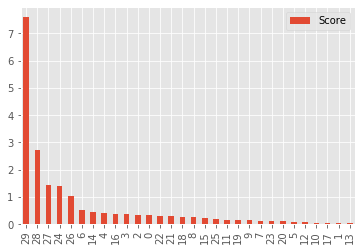

In [17]:
importance = logit_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent Classifier

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

SGD Baseline recall score:  0.9137931034482759


In [20]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=5, scoring='recall', n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.09 s, sys: 73.3 ms, total: 2.16 s
Wall time: 4.76 s


GridSearchCV(cv=5,
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring='recall')

In [21]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))

SGD Grid Search best params:  {'alpha': 0.00022413793103448276, 'max_iter': 100}
SGD Grid Search Training set recall score:  0.985735418427726
SGD Best Estimator Validation set recall score:  0.9310344827586207
SGD Best Estimator Validation set business score:  0.7919694861089634


,Feature,Score
29,isFraudConnected,19.598088
26,Both_Service,7.205431
24,NetworkDegree,5.088041
28,Outpatient,2.300959
6,Avg_Cost,1.964872
16,ChronicCond_Cancer,1.603792
22,ChronicCond_rheumatoidarthritis,1.455119
8,Gender1,1.282482
0,Phys_Count,1.070659
4,Duplicate_Claims_Percent,1.066556


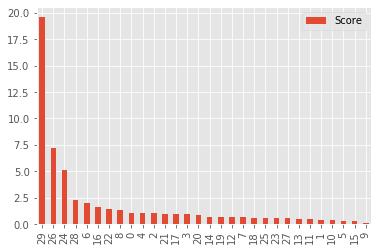

In [22]:
importance = sgd_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### K-Nearest Neighbors

In [23]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("KNN Baseline Training Set recall score: ", recall_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

KNN Baseline Training Set recall score:  0.9916765755053508
KNN Baseline Validation Set recall score:  0.7413793103448276


In [24]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = 'recall')

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring='recall', verbose=1)

In [25]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))

KNN Grid Search Best params:  {'n_neighbors': 73}
KNN Grid Search Training set Recall score:  0.9560047562425684
KNN Grid Search Validation set Recall score:  0.8448275862068966
KNN Grid Search Validation set business score:  0.5638884593577651


In [27]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[159,  52],
       [  9,  49]])

### Support Vector Machine

In [31]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

SVC(class_weight='balanced')

In [32]:
# baseline score
svm_train_recall = recall_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('SVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

SVM BaseLine Train Set Recall Score: 0.93935790725327
SVM BaseLine Validation Set Recall Score: 0.8448275862068966


In [33]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = 'recall')
svm_GS.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring='recall', verbose=1)

In [34]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))

SVM Grid Search Best params:  {'C': 0.21544346900318834, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  0.9678953626634959
SVM Grid Search Validation set Recall score:  0.9137931034482759
Test Set business Score: 0.7451162311221071


In [ ]:
#recall = TP / (TP+FN) 
confusion_matrix(y_test, best_svm.predict(X_test))

### Discriminant Analysis

In [28]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train_Bal, y_train_Bal)

LinearDiscriminantAnalysis()

In [29]:
y_predict = LDA.predict(X_test)
print("LDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("LDA Baseline validation set business score: ", businessgain(y_test,y_predict))

LDA Baseline validation set recall score:  0.7241379310344828
LDA Baseline validation set business score:  0.41322612236482653


In [30]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X_train_Bal, y_train_Bal)
y_predict = QDA.predict(X_test)

print("QDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("QDA Baseline validation set business score: ", businessgain(y_test,y_predict))


QDA Baseline validation set recall score:  0.8275862068965517
QDA Baseline validation set business score:  0.6180609246946034


/home/truong/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Random Forest

In [35]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('RF BaseLine Train Set Recall Score:', recall_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.896551724137931


In [36]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='recall', cv=5, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 21.2 s, sys: 715 ms, total: 21.9 s
Wall time: 3min 45s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring='recall')

In [37]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 40}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.8793103448275862
RF Grid Search Validation set Business score:  0.7380031957115613


### XG BOOST 

In [38]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
print('XGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.8793103448275862


In [40]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 } 

In [41]:
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring='recall', cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 1.41 s, sys: 17.3 ms, total: 1.42 s
Wall time: 4.41 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree

In [42]:
grid_search_xgb.best_params_

{'learning_rate': 0.001,
 'max_depth': 1,
 'n_estimators': 2,
 'scale_pos_weight': 400,
 'subsample': 0.9}

In [43]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 1.0
XGB BaseLine Validation Set business Score: 0.5794031235503324


In [44]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[  7, 204],
       [  0,  58]])

## Unsupervised Learning

### Principal Component Analysis

In [45]:
from sklearn.decomposition import PCA
pca = PCA()
pca.set_params(n_components=3)

PCA(n_components=3)

In [46]:
pca.set_params(n_components=22).fit(X_train_Bal)
x_train2 = pca.transform(X_train_Bal)
x_test2 = pca.transform(X_test) # transformation

In [47]:
import sklearn.linear_model as lm
logit = lm.LogisticRegression()
logit.fit(x_train2, y_train_Bal)
print("PCA Logistic Regression Train recall score: ", recall_score(y_train_Bal,logit.predict(x_train2)))
print("PCA Logistic Regression Validation recall score: ", recall_score(y_test,logit.predict(x_test2)))
print("PCA Logistic Regression Validation business score: ", businessgain(y_test,logit.predict(x_test2)))

PCA Logistic Regression Train recall score:  0.9655172413793104
PCA Logistic Regression Validation recall score:  0.8793103448275862
PCA Logistic Regression Validation business score:  0.7359414463172002
